## 1. Load Data

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patheffects
import pandas as pd
import seaborn as sns
import json, copy

In [5]:
# OPTION 1: baseline and fine-tuning separate

# load baselines: filename!!
with open('results_jsons/baselines_freeze_True_pool_False_lr_0.001_random_classes.json', 'r') as f:
    baselines = json.load(f)
baselines = baselines[1:]

# load results; filename
with open('results_jsons/results_freeze_True_reinit_True_pool_False_random_classes.json', 'r') as f:
    results = json.load(f)

# Run this if the first element of the results is the PARAMS dict
params = results[0]
results = results[1:]
# if not, initialize a params dict -see 3. Init params

data_dicts = baselines + results 
# Create DataFrame from the list of dictionaries
df = pd.DataFrame(data_dicts)

In [17]:
# OPTION 2: baseline and fine-tuning in the same json

# load results; filename
with open('results_jsons/results_freeze_True_reinit_True_pool_False_lr_0.001_seed_subsamples.json', 'r') as f:
    results = json.load(f)

# Run this if the first element of the results is the PARAMS dict
params = results[0]
results = results[1:]
# if not, initialize a params dict -see 3. Init params

# Create DataFrame from the list of dictionaries
df = pd.DataFrame(results)

FileNotFoundError: [Errno 2] No such file or directory: 'results_jsons/results_freeze_True_reinit_True_pool_False_lr_0.001_seed_subsamples.json'

In [6]:
# Calculate mean, median, and max for train and test accuracies
df['Mean Train Accuracy'] = df.groupby(['lr', 'sampled_percentage', 'sampled_cut_point'])['train_acc'].transform('mean')
df['Median Train Accuracy'] = df.groupby(['lr', 'sampled_percentage', 'sampled_cut_point'])['train_acc'].transform('median')
df['Mean Test Accuracy'] = df.groupby(['lr', 'sampled_percentage', 'sampled_cut_point'])['test_acc'].transform('mean')
df['Median Test Accuracy'] = df.groupby(['lr', 'sampled_percentage', 'sampled_cut_point'])['test_acc'].transform('median')
df['Max Test Accuracy'] = df.groupby(['lr', 'sampled_percentage', 'sampled_cut_point'])['test_acc'].transform('max')
df['Max Train Accuracy'] = df.groupby(['lr', 'sampled_percentage', 'sampled_cut_point'])['train_acc'].transform('max')

# Rename the columns to match the specified names
df.rename(columns={
    'lr': 'learning rate',
    'sampled_percentage': 'Percentage',
    'sampled_cut_point': 'Cut Point',
    'repeat': 'Trial',
    'train_acc': 'Train Accuracy',
    'test_acc': 'Test Accuracy'
}, inplace=True)

# Display the DataFrame (showing the first few rows for brevity)
df.head()


,learning rate,Percentage,Cut Point,Trial,Train Accuracy,Test Accuracy,Mean Train Accuracy,Median Train Accuracy,Mean Test Accuracy,Median Test Accuracy,Max Test Accuracy,Max Train Accuracy
0,0.001,0.001,-1,0,1.0,0.835500,0.997333,1.0,0.897444,0.900389,0.966889,1.0
1,0.001,0.001,-1,1,1.0,0.912000,0.997333,1.0,0.897444,0.900389,0.966889,1.0
2,0.001,0.001,-1,2,1.0,0.928333,0.997333,1.0,0.897444,0.900389,0.966889,1.0
3,0.001,0.001,-1,3,1.0,0.900167,0.997333,1.0,0.897444,0.900389,0.966889,1.0
4,0.001,0.001,-1,4,1.0,0.904722,0.997333,1.0,0.897444,0.900389,0.966889,1.0


# 2. The plots

## Important Plots!!

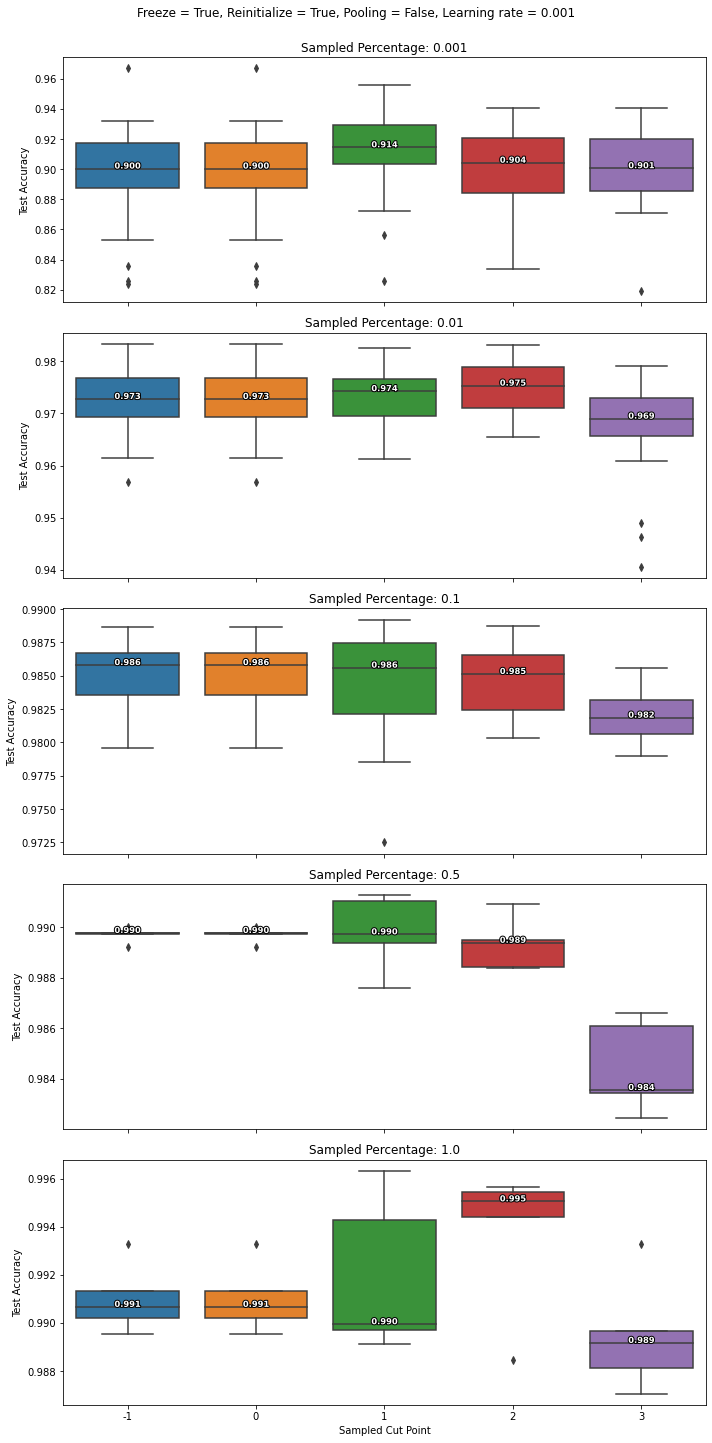

In [8]:
lim = 0.45  #cut the y-axis: so the plots have the same range

# Creating subplots for each data percentage
unique_percentages = df['Percentage'].unique()
#unique_percentages = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1]
n_percentages = len(unique_percentages)

# Adjusting the subplot layout for better readability of median values (improving contrast)
fig, axes = plt.subplots(nrows=n_percentages, ncols=1, figsize=(10, 20), sharex=True)

for i, percentage in enumerate(sorted(unique_percentages)):
    # Filtering data for each percentage
    df_subset = df[df['Percentage'] == percentage]
    
    # Creating a boxplot for the current percentage
    sns.boxplot(x='Cut Point', y='Test Accuracy', data=df_subset, ax=axes[i])
    axes[i].set_title(f'Sampled Percentage: {percentage}')
    axes[i].set_xlabel('Sampled Cut Point')
    # axes[i].set_ylim(lim, 1.0)
    # axes[i].set_yscale('log')

    if i == n_percentages - 1:
        axes[i].set_xlabel('Sampled Cut Point')
    else:
        axes[i].set_xlabel('')
    axes[i].set_ylabel('Test Accuracy')

    # Annotating each boxplot with the median value and adjusting for better contrast
    medians = df_subset.groupby(['Cut Point'])['Test Accuracy'].median().sort_index()
    for j, median in enumerate(medians):
        text = axes[i].text(j, median, f'{median:.3f}', 
                            horizontalalignment='center', size='small', color='white', weight='semibold')
        text.set_path_effects([patheffects.withStroke(linewidth=2, foreground="black")])
st = fig.suptitle(f'Freeze = {params["freeze"]}, Reinitialize = {params["reinit"]}, Pooling = {params["use_pooling"]}, Learning rate = {params["lr_fine_tune"]}')

st.set_y(1.0)
fig.subplots_adjust(top=0.85)
plt.tight_layout()
plt.show()


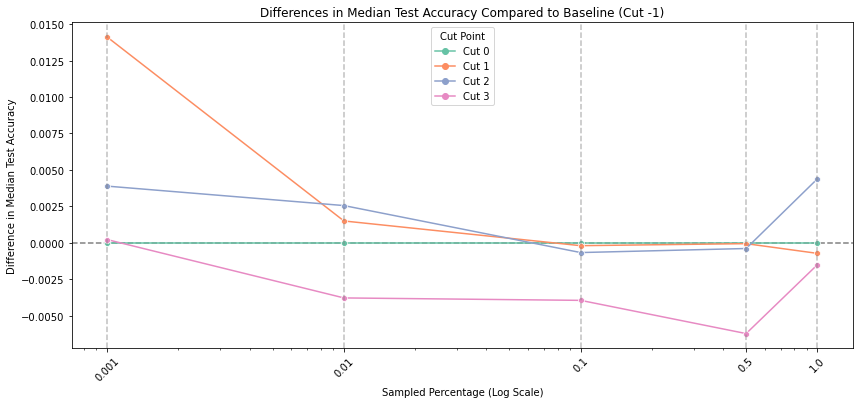

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_combined is your original DataFrame

# Grouping by sampled_percentage, sampled_cut_point and calculating medians
medians_by_cut = df.groupby(['Percentage', 'Cut Point'])['Test Accuracy'].median().reset_index()

# Pivoting the table for easier calculation of differences
pivot_medians = medians_by_cut.pivot(index='Percentage', columns='Cut Point', values='Test Accuracy')

# Identifying all unique cut points except for the baseline (-1)
cut_points = [col for col in pivot_medians.columns if col != -1]

# Calculating differences from baseline for each cut point
for cut in cut_points:
    pivot_medians[f'diff_cut_{cut}'] = pivot_medians[cut] - pivot_medians[-1]

# Resetting index to make 'sampled_percentage' a column
pivot_medians.reset_index(inplace=True)

# Removing rows with NaN values in the new difference columns
pivot_medians.dropna(subset=[f'diff_cut_{cut}' for cut in cut_points], inplace=True)

# Plot setup
plt.figure(figsize=(14, 6))
palette = sns.color_palette("Set2", len(cut_points))  # Setting palette based on number of cut points
plt.title('Differences in Median Test Accuracy Compared to Baseline (Cut -1)')
plt.xlabel('Sampled Percentage (Log Scale)')
plt.ylabel('Difference in Median Test Accuracy')
plt.axhline(0, color='gray', linestyle='--')  # Reference line at zero

# Plotting the differences for each cut
for i, cut in enumerate(cut_points):
    sns.lineplot(x='Percentage', y=f'diff_cut_{cut}', data=pivot_medians, marker='o', color=palette[i])

# Adding vertical dashed lines for each sampled percentage
for percentage in pivot_medians['Percentage'].unique():
    plt.axvline(percentage, color='gray', linestyle='--', alpha=0.5)

plt.xscale('log')
plt.xticks(pivot_medians['Percentage'], labels=pivot_medians['Percentage'], rotation=45)

# Custom legend
legend_labels = [f'Cut {cut}' for cut in cut_points]
plt.legend(title='Cut Point', labels=legend_labels, handles=[plt.Line2D([0], [0], color=palette[i], marker='o') for i in range(len(cut_points))])

plt.show()

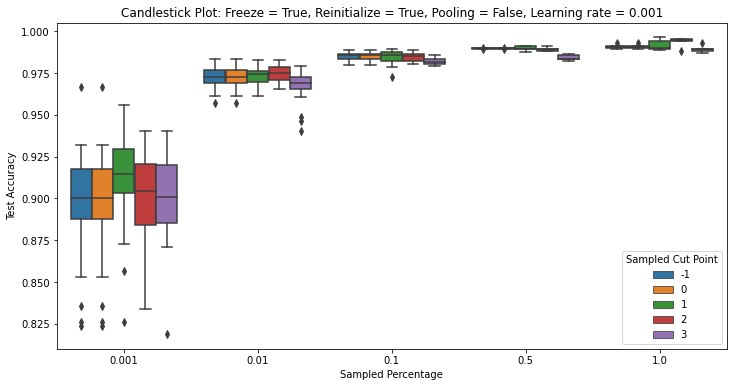

In [9]:
# Creating boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(x='Percentage', y='Test Accuracy', hue='Cut Point', data=df)
plt.title(f'Candlestick Plot: Freeze = {params["freeze"]}, Reinitialize = {params["reinit"]}, Pooling = {params["use_pooling"]}, Learning rate = {params["lr_fine_tune"]}')
plt.xlabel('Sampled Percentage')
plt.ylabel('Test Accuracy')
plt.legend(title='Sampled Cut Point')
plt.show()

## Backup Plots

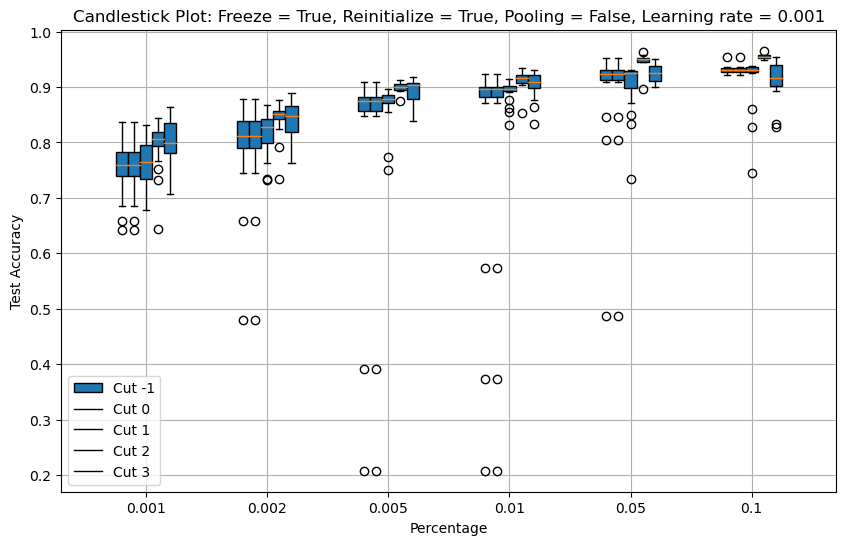

In [39]:
# Unique percentages and cut points
percentages = df['Percentage'].unique()
cut_points = df['Cut Point'].unique()

# Plotting
plt.figure(figsize=(10, 6))

# Iterate over each unique cut point
for cut_point in cut_points:
    cut_df = df[df['Cut Point'] == cut_point]

    # Create a list of arrays, each containing test accuracies for a given percentage
    data = [cut_df[cut_df['Percentage'] == p]['Test Accuracy'].values for p in percentages]

    # Position for the candle plots for this cut point
    positions = np.array(range(len(percentages))) + cut_point * 0.1  # slight offset for each cut point

    # Create boxplot (candlestick plot)
    plt.boxplot(data, positions=positions, widths=0.1, patch_artist=True, labels=percentages if cut_point == 1 else None)

positions = np.array(range(len(percentages))) + 0.1
plt.xticks(positions, [round(p, 3) for p in percentages])

plt.xlabel('Percentage')
plt.ylabel('Test Accuracy')
plt.title(f'Candlestick Plot: Freeze = {params["freeze"]}, Reinitialize = {params["reinit"]}, Pooling = {params["use_pooling"]}, Learning rate = {params["lr_fine_tune"]}')
plt.legend([f'Cut {cp}' for cp in cut_points])
plt.grid(True)
plt.show()


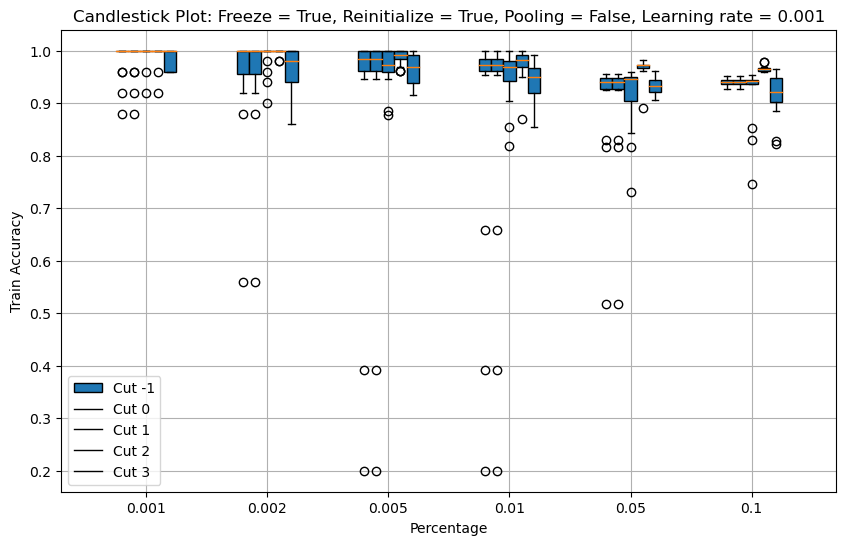

In [38]:
# Unique percentages and cut points
percentages = df['Percentage'].unique()
cut_points = df['Cut Point'].unique()

# Plotting
plt.figure(figsize=(10, 6))


# Iterate over each unique cut point
for cut_point in cut_points:
    cut_df = df[df['Cut Point'] == cut_point]

    # Create a list of arrays, each containing test accuracies for a given percentage
    data = [cut_df[cut_df['Percentage'] == p]['Train Accuracy'].values for p in percentages]

    # Position for the candle plots for this cut point
    positions = np.array(range(len(percentages))) + cut_point * 0.1  # slight offset for each cut point

    # Create boxplot (candlestick plot)
    plt.boxplot(data, positions=positions, widths=0.1, patch_artist=True, labels=percentages if cut_point == 1 else None)

positions = np.array(range(len(percentages))) + 0.1
plt.xticks(positions, [round(p, 3) for p in percentages])

plt.xlabel('Percentage')
plt.ylabel('Train Accuracy')
plt.title(f'Candlestick Plot: Freeze = {params["freeze"]}, Reinitialize = {params["reinit"]}, Pooling = {params["use_pooling"]}, Learning rate = {params["lr_fine_tune"]}')
plt.legend([f'Cut {cp}' for cp in cut_points])
plt.grid(True)
plt.show()


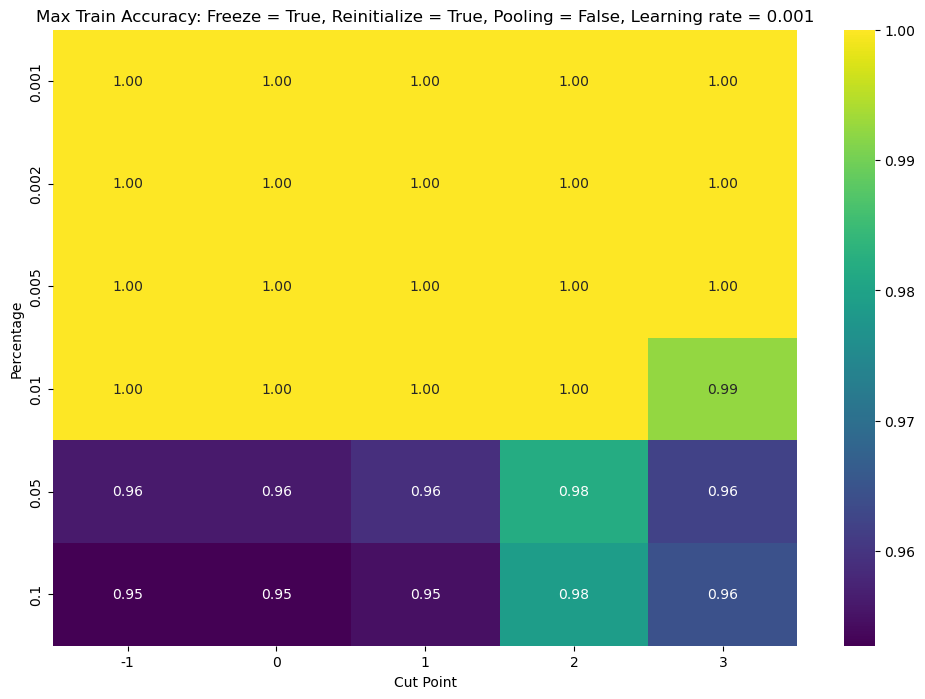

In [40]:
# For the heatmap, we will use the mean test accuracy, aggregated over trials for each combination of 'Percentage' and 'Cut Point'

# We will pivot the dataframe to get the mean test accuracy for each combination of 'Percentage' and 'Cut Point'
heatmap_data = df.pivot_table(index='Percentage', columns='Cut Point', values='Max Train Accuracy', aggfunc='max')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".2f")
plt.title(f'Max Train Accuracy: Freeze = {params["freeze"]}, Reinitialize = {params["reinit"]}, Pooling = {params["use_pooling"]}, Learning rate = {params["lr_fine_tune"]}')
plt.xlabel('Cut Point')
plt.ylabel('Percentage')
plt.show()

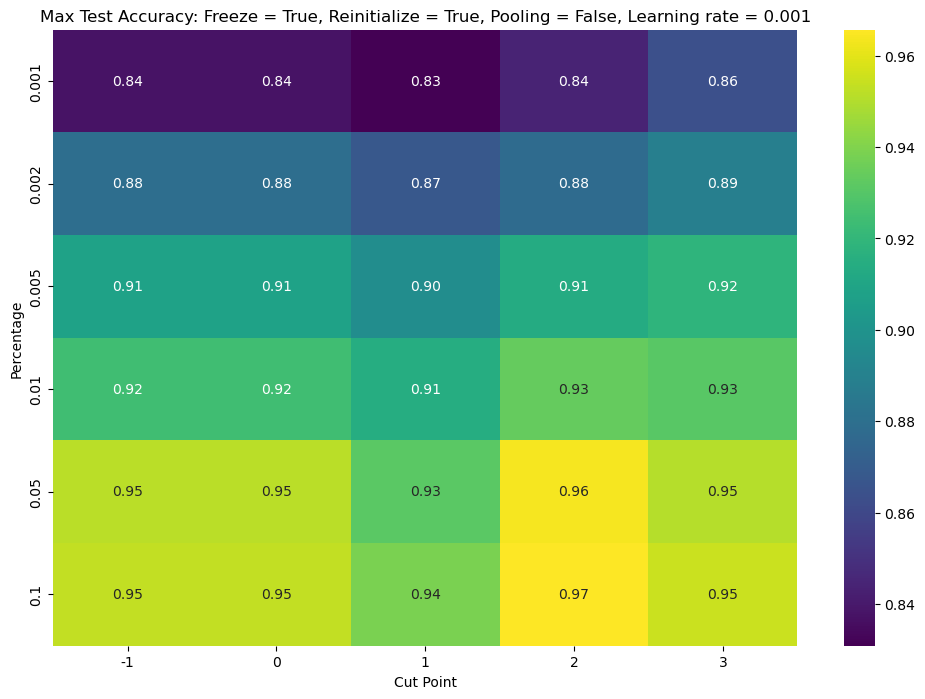

In [41]:
# For the heatmap, we will use the mean test accuracy, aggregated over trials for each combination of 'Percentage' and 'Cut Point'

# We will pivot the dataframe to get the mean test accuracy for each combination of 'Percentage' and 'Cut Point'
heatmap_data = df.pivot_table(index='Percentage', columns='Cut Point', values='Max Test Accuracy', aggfunc='max')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".2f")
plt.title(f'Max Test Accuracy: Freeze = {params["freeze"]}, Reinitialize = {params["reinit"]}, Pooling = {params["use_pooling"]}, Learning rate = {params["lr_fine_tune"]}')
plt.xlabel('Cut Point')
plt.ylabel('Percentage')
plt.show()


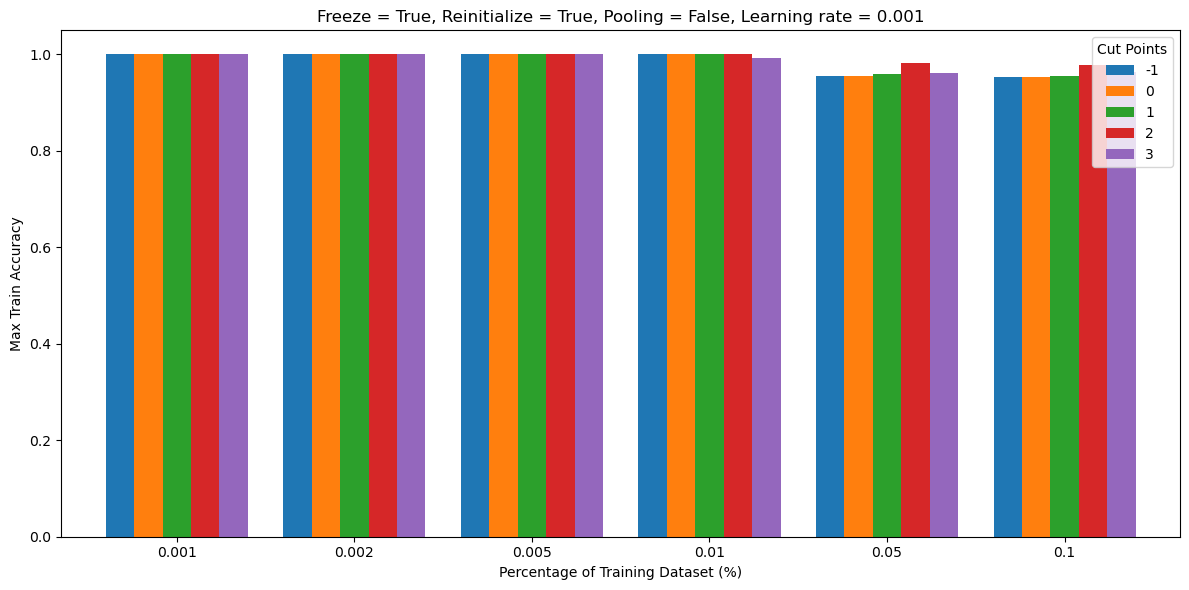

In [42]:
# Create a bar graph for comparing the test accuracies of different cut points at each percentage level.

# Find the mean test accuracy for each cut point at each percentage level.
mean_accuracies = df.groupby(['Cut Point', 'Percentage']).mean()['Max Train Accuracy'].unstack(0)

# Plotting
mean_accuracies.plot(kind='bar', figsize=(12, 6), width=0.8)

plt.title(f'Freeze = {params["freeze"]}, Reinitialize = {params["reinit"]}, Pooling = {params["use_pooling"]}, Learning rate = {params["lr_fine_tune"]}')
plt.xlabel('Percentage of Training Dataset (%)')
plt.ylabel('Max Train Accuracy')
plt.xticks(rotation=0)  # Rotate x-axis labels to show them horizontally.
plt.legend(title='Cut Points')
plt.tight_layout()
plt.show()


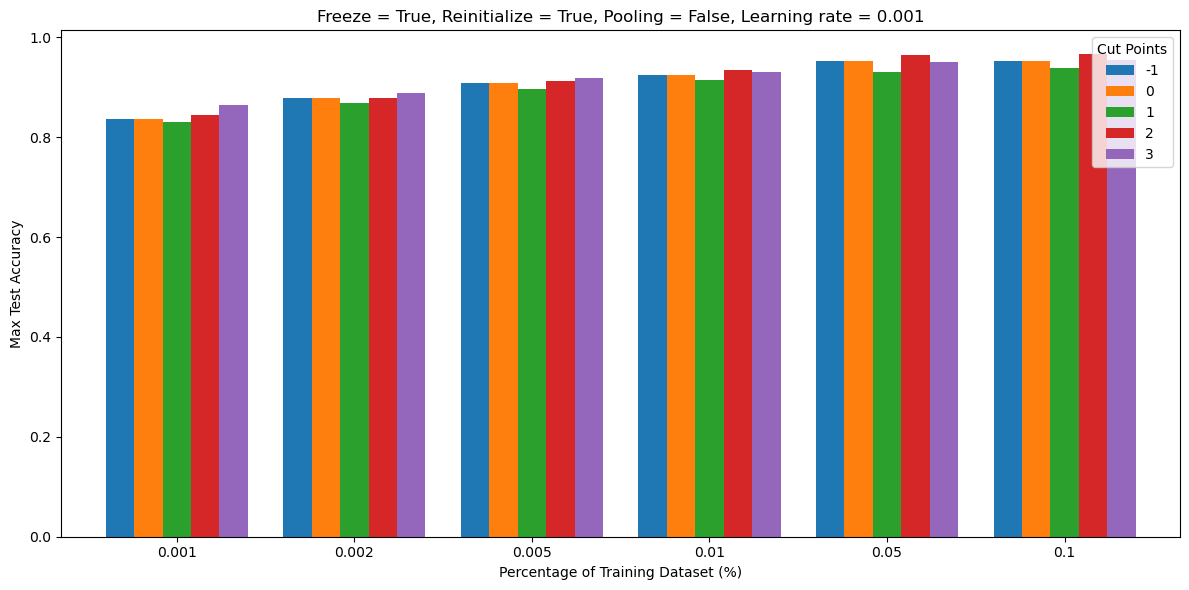

In [43]:
# Create a bar graph for comparing the test accuracies of different cut points at each percentage level.

# Find the mean test accuracy for each cut point at each percentage level.
mean_accuracies = df.groupby(['Cut Point', 'Percentage']).mean()['Max Test Accuracy'].unstack(0)

# Plotting
mean_accuracies.plot(kind='bar', figsize=(12, 6), width=0.8)

plt.title(f'Freeze = {params["freeze"]}, Reinitialize = {params["reinit"]}, Pooling = {params["use_pooling"]}, Learning rate = {params["lr_fine_tune"]}')
plt.xlabel('Percentage of Training Dataset (%)')
plt.ylabel('Max Test Accuracy')
plt.xticks(rotation=0)  # Rotate x-axis labels to show them horizontally.
plt.legend(title='Cut Points')
plt.tight_layout()
plt.show()


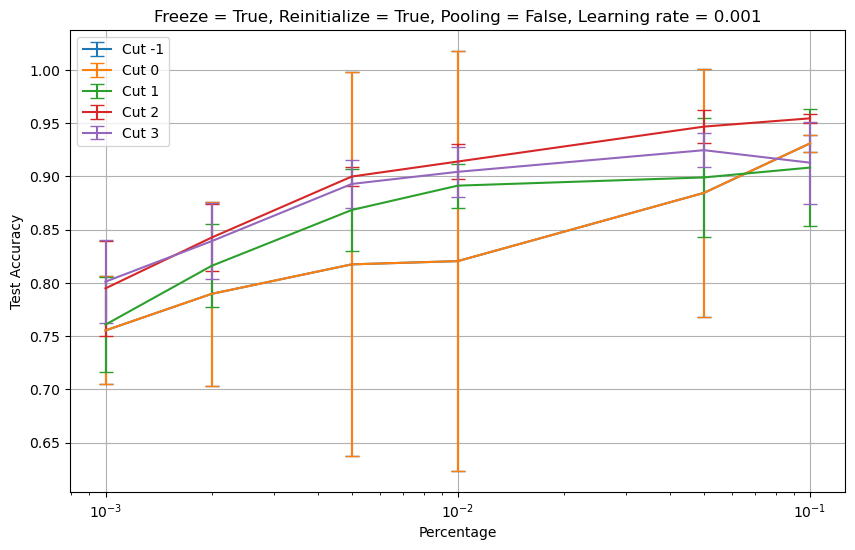

In [45]:
# Calculate mean and standard deviation for test accuracies
# Assuming that the provided data has a pattern where every three tuples belong to the same
# percentage and cut point but different trials
df['Mean Test Accuracy'] = df.groupby(['Percentage', 'Cut Point'])['Test Accuracy'].transform('mean')
df['Std Test Accuracy'] = df.groupby(['Percentage', 'Cut Point'])['Test Accuracy'].transform('std')

# Plotting
plt.figure(figsize=(10, 6))

# Iterate over each unique cut point
for cut_point in df['Cut Point'].unique():
    cut_df = df[df['Cut Point'] == cut_point]

    # Calculate mean and standard deviation for each percentage
    means = cut_df.groupby('Percentage')['Mean Test Accuracy'].mean()
    stds = cut_df.groupby('Percentage')['Std Test Accuracy'].mean()

    # Plot with error bars for uncertainty
    plt.errorbar(means.index, means, yerr=stds, capsize=5, label=f'Cut {cut_point}')
    #plt.errorbar(means.index, means, capsize=5, label=f'Cut {cut_point}')


plt.xlabel('Percentage')
plt.ylabel('Test Accuracy')
plt.title(f'Freeze = {params["freeze"]}, Reinitialize = {params["reinit"]}, Pooling = {params["use_pooling"]}, Learning rate = {params["lr_fine_tune"]}')
plt.legend()
#x log
plt.xscale('log')
plt.grid(True)
plt.show()

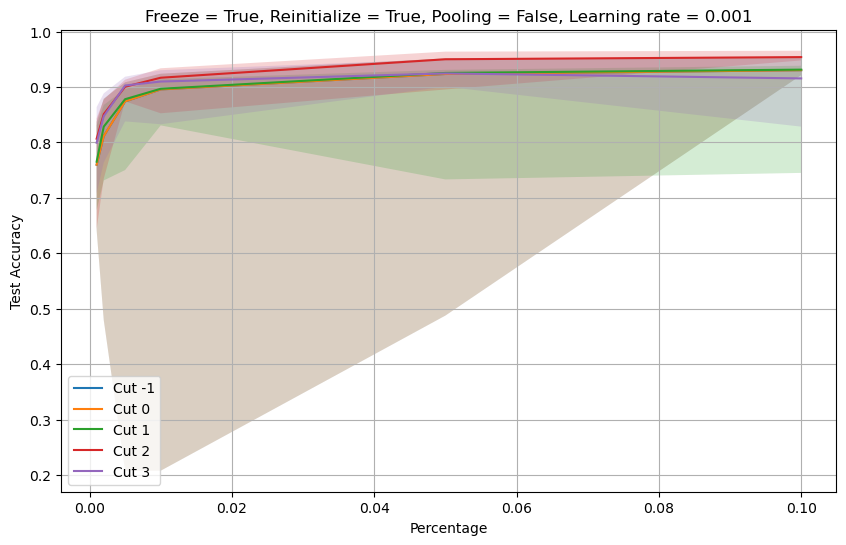

In [47]:
# Adjusting the code to use minimum, maximum, and median values instead of mean and standard deviation

# Calculate median, min, and max for test accuracies
df['Median Test Accuracy'] = df.groupby(['Percentage', 'Cut Point'])['Test Accuracy'].transform('median')
df['Min Test Accuracy'] = df.groupby(['Percentage', 'Cut Point'])['Test Accuracy'].transform('min')
df['Max Test Accuracy'] = df.groupby(['Percentage', 'Cut Point'])['Test Accuracy'].transform('max')

# Plotting
plt.figure(figsize=(10, 6))

# Iterate over each unique cut point
for cut_point in df['Cut Point'].unique():
    cut_df = df[df['Cut Point'] == cut_point]

    # Calculate median, min, and max for each percentage
    medians = cut_df.groupby('Percentage')['Median Test Accuracy'].median()
    mins = cut_df.groupby('Percentage')['Min Test Accuracy'].min()
    maxs = cut_df.groupby('Percentage')['Max Test Accuracy'].max()

    # Plot median values
    plt.plot(medians.index, medians, label=f'Cut {cut_point}')

    # Plot intervals between min and max as shaded areas
    plt.fill_between(medians.index, mins, maxs, alpha=0.2)

plt.xlabel('Percentage')
plt.ylabel('Test Accuracy')
plt.title(f'Freeze = {params["freeze"]}, Reinitialize = {params["reinit"]}, Pooling = {params["use_pooling"]}, Learning rate = {params["lr_fine_tune"]}')
plt.legend()
plt.grid(True)
plt.show()


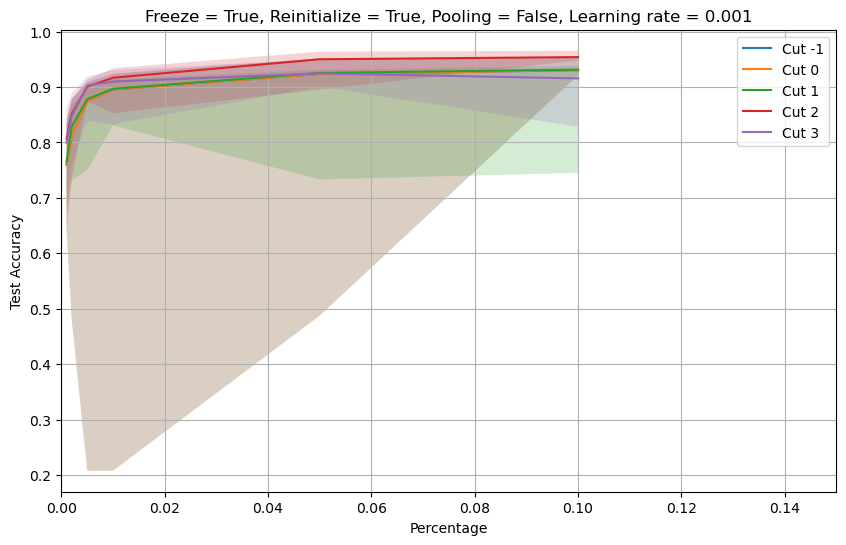

In [48]:
# Adjusting the code to use minimum, maximum, and median values instead of mean and standard deviation

# Calculate median, min, and max for test accuracies
df['Median Test Accuracy'] = df.groupby(['Percentage', 'Cut Point'])['Test Accuracy'].transform('median')
df['Min Test Accuracy'] = df.groupby(['Percentage', 'Cut Point'])['Test Accuracy'].transform('min')
df['Max Test Accuracy'] = df.groupby(['Percentage', 'Cut Point'])['Test Accuracy'].transform('max')

# Plotting
plt.figure(figsize=(10, 6))

# Iterate over each unique cut point
for cut_point in df['Cut Point'].unique():
    cut_df = df[df['Cut Point'] == cut_point]

    # Calculate median, min, and max for each percentage
    medians = cut_df.groupby('Percentage')['Median Test Accuracy'].median()
    mins = cut_df.groupby('Percentage')['Min Test Accuracy'].min()
    maxs = cut_df.groupby('Percentage')['Max Test Accuracy'].max()

    # Plot median values
    plt.plot(medians.index, medians, label=f'Cut {cut_point}')

    # Plot intervals between min and max as shaded areas
    plt.fill_between(medians.index, mins, maxs, alpha=0.2)

plt.xlabel('Percentage')
plt.ylabel('Test Accuracy')
plt.title(f'Freeze = {params["freeze"]}, Reinitialize = {params["reinit"]}, Pooling = {params["use_pooling"]}, Learning rate = {params["lr_fine_tune"]}')
plt.legend()
plt.grid(True)
#plt.xscale('log')
#x limit to 0.3
plt.xlim(0, 0.15)
plt.show()


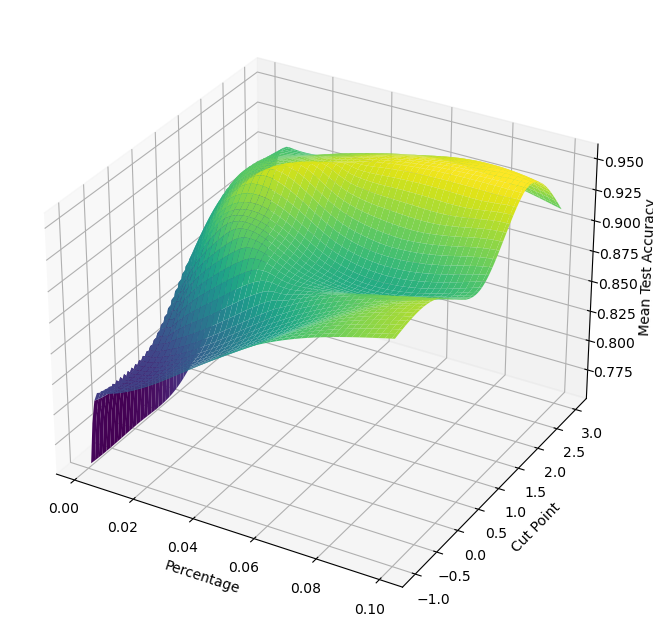

In [49]:
from scipy.interpolate import griddata

# Create grid values
xi = np.linspace(df['Percentage'].min(), df['Percentage'].max(), 100)
yi = np.linspace(df['Cut Point'].min(), df['Cut Point'].max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate
zi = griddata((df['Percentage'], df['Cut Point']), df['Mean Test Accuracy'], (xi, yi), method='cubic')

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xi, yi, zi, cmap='viridis')
ax.set_xlabel('Percentage')
ax.set_ylabel('Cut Point')
ax.set_zlabel('Mean Test Accuracy')
plt.show()

# 3. Init params
Don't forget to change the flags to the correct ones for the titles!

In [1]:
import json

In [2]:
from torch import nn
# Changes Here for the experiments
params = {
      # MODEL ARCHITECTURE PARAMS
      'depth': 5,
      'width': 30, # num channels for CNN
      # 'hidden_dim_lin': 128,
      'activation_function': str(nn.ReLU),
      'kernel_size': 3,
      # TRAINING PARAMS
      'lr_pretrain': 0.001,   
      'lr_fine_tune': 0.001,  # CHANGE: if no layer-wise lr
      # 'lr_fine_tune_reinit': 0.001,         # CHANGE: if no layer-wise lr
      # 'lr_fine_tune_no_reinit': 0.0001,     # CHANGE: if layer-wise lr
      'num_train': 40,
      'early_stop_patience': 6,
      'save_best': False,
      'save_checkpoints': False,
      'is_cnn': True,
      'is_debug': False,
      'classification_report_flag': False,
      'batch_size':4096,
      # DATASET PARAMS
      'pre_train_classes': [0, 1, 2, 3, 4, 6, 8],
      'fine_tune_classes': [5, 7, 9],
        'val_split': 0.1,
      'num_workers': 0,
      'generate_dataset_seed': 42,
      # EXPERIMENT SETTING PARAMS
      'percentages':[0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1],
      'use_pooling': False,   # CHANGE
      'freeze': True,         # CHANGE: freeze the conv layers before the cut
      'reinit': False,         # CHANGE: reinit the conv lyers only after the cut
      'reinit_both_dense': True   # CHANGE: True for reinitialize both dense layers, False for reinit only the last dense layer
    }

### Extra 1: Split the dictionaries into baseline and fine-tuning one
only run when necessary

In [23]:
with open('results_jsons/merged_freeze_no_reinit_no_pool_lr_0.0001.json', 'r') as f:
    data_dicts = json.load(f)

baselines = [params]
results = [params]
for row in data_dicts:
    if row["sampled_cut_point"] == -1:
        baselines.append(row)
    else:
        results.append(row)

with open(f'results_jsons/baselines_freeze_{params["freeze"]}_pool_{params["use_pooling"]}_lr_{params["lr_fine_tune"]}.json', 'w') as f:
    json.dump(baselines, f)
with open(f'results_jsons/results_freeze_{params["freeze"]}_reinit_{params["reinit"]}_pool_{params["use_pooling"]}_lr_{params["lr_fine_tune"]}.json', 'w') as f:
    json.dump(results, f)

### Extra 2: Parse Cell outputs
Works only with the standart cell output -see the next cell

In [2]:
# copy the cell output here
out = """
Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 0.9802, Test Accuracy: 0.9623

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 1
Early stopping invoked.
Training Accuracy: 0.9751, Test Accuracy: 0.9597

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 2
Early stopping invoked.
Training Accuracy: 0.9755, Test Accuracy: 0.9647

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 3
Early stopping invoked.
Training Accuracy: 0.9805, Test Accuracy: 0.9577

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 4
Early stopping invoked.
Training Accuracy: 0.9782, Test Accuracy: 0.9647

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 5
Early stopping invoked.
Training Accuracy: 0.9749, Test Accuracy: 0.9567

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 6
Early stopping invoked.
Training Accuracy: 0.9716, Test Accuracy: 0.9610

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 7
Early stopping invoked.
Training Accuracy: 0.9558, Test Accuracy: 0.9520

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 8
Early stopping invoked.
Training Accuracy: 0.9811, Test Accuracy: 0.9673

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 9
Early stopping invoked.
Training Accuracy: 0.9601, Test Accuracy: 0.9513

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 10
Early stopping invoked.
Training Accuracy: 0.9790, Test Accuracy: 0.9660

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 11
Early stopping invoked.
Training Accuracy: 0.9790, Test Accuracy: 0.9653

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 12
Early stopping invoked.
Training Accuracy: 0.9722, Test Accuracy: 0.9593

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 13
Early stopping invoked.
Training Accuracy: 0.9813, Test Accuracy: 0.9600

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 14
Training Accuracy: 0.9877, Test Accuracy: 0.9647

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 15
Early stopping invoked.
Training Accuracy: 0.9831, Test Accuracy: 0.9627

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 16
Early stopping invoked.
Training Accuracy: 0.9840, Test Accuracy: 0.9603

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 17
Early stopping invoked.
Training Accuracy: 0.9788, Test Accuracy: 0.9597

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 18
Training Accuracy: 0.9893, Test Accuracy: 0.9640

Sampled Percentage: 0.3, Sampled Cut Point: 0, Lr: 0.001, Repeat: 19
Early stopping invoked.
Training Accuracy: 0.9761, Test Accuracy: 0.9610

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 0.9798, Test Accuracy: 0.9633

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 1
Early stopping invoked.
Training Accuracy: 0.9877, Test Accuracy: 0.9617

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 2
Early stopping invoked.
Training Accuracy: 0.9634, Test Accuracy: 0.9557

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 3
Early stopping invoked.
Training Accuracy: 0.9784, Test Accuracy: 0.9583

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 4
Early stopping invoked.
Training Accuracy: 0.9710, Test Accuracy: 0.9610

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 5
Early stopping invoked.
Training Accuracy: 0.9794, Test Accuracy: 0.9563

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 6
Early stopping invoked.
Training Accuracy: 0.9700, Test Accuracy: 0.9610

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 7
Early stopping invoked.
Training Accuracy: 0.9817, Test Accuracy: 0.9653

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 8
Early stopping invoked.
Training Accuracy: 0.9774, Test Accuracy: 0.9607

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 9
Early stopping invoked.
Training Accuracy: 0.9772, Test Accuracy: 0.9627

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 10
Early stopping invoked.
Training Accuracy: 0.9712, Test Accuracy: 0.9587

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 11
Early stopping invoked.
Training Accuracy: 0.9798, Test Accuracy: 0.9627

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 12
Training Accuracy: 0.9811, Test Accuracy: 0.9643

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 13
Early stopping invoked.
Training Accuracy: 0.9757, Test Accuracy: 0.9607

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 14
Early stopping invoked.
Training Accuracy: 0.9730, Test Accuracy: 0.9603

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 15
Training Accuracy: 0.9922, Test Accuracy: 0.9630

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 16
Early stopping invoked.
Training Accuracy: 0.9835, Test Accuracy: 0.9613

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 17
Early stopping invoked.
Training Accuracy: 0.9685, Test Accuracy: 0.9577

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 18
Training Accuracy: 0.9903, Test Accuracy: 0.9653

Sampled Percentage: 0.3, Sampled Cut Point: 1, Lr: 0.001, Repeat: 19
Early stopping invoked.
Training Accuracy: 0.9815, Test Accuracy: 0.9633

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 0.9858, Test Accuracy: 0.9663

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 1
Early stopping invoked.
Training Accuracy: 0.9825, Test Accuracy: 0.9637

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 2
Early stopping invoked.
Training Accuracy: 0.9813, Test Accuracy: 0.9643

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 3
Early stopping invoked.
Training Accuracy: 0.9753, Test Accuracy: 0.9607

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 4
Early stopping invoked.
Training Accuracy: 0.9829, Test Accuracy: 0.9620

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 5
Training Accuracy: 0.9858, Test Accuracy: 0.9583

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 6
Early stopping invoked.
Training Accuracy: 0.9780, Test Accuracy: 0.9657

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 7
Training Accuracy: 0.9920, Test Accuracy: 0.9667

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 8
Early stopping invoked.
Training Accuracy: 0.9811, Test Accuracy: 0.9657

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 9
Training Accuracy: 0.9879, Test Accuracy: 0.9623

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 10
Early stopping invoked.
Training Accuracy: 0.9745, Test Accuracy: 0.9620

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 11
Early stopping invoked.
Training Accuracy: 0.9835, Test Accuracy: 0.9627

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 12
Early stopping invoked.
Training Accuracy: 0.9698, Test Accuracy: 0.9613

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 13
Early stopping invoked.
Training Accuracy: 0.9698, Test Accuracy: 0.9603

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 14
Early stopping invoked.
Training Accuracy: 0.9854, Test Accuracy: 0.9660

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 15
Early stopping invoked.
Training Accuracy: 0.9872, Test Accuracy: 0.9620

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 16
Early stopping invoked.
Training Accuracy: 0.9778, Test Accuracy: 0.9567

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 17
Training Accuracy: 0.9879, Test Accuracy: 0.9613

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 18
Training Accuracy: 0.9891, Test Accuracy: 0.9623

Sampled Percentage: 0.3, Sampled Cut Point: 2, Lr: 0.001, Repeat: 19
Early stopping invoked.
Training Accuracy: 0.9780, Test Accuracy: 0.9627

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 0.9683, Test Accuracy: 0.9570

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 1
Early stopping invoked.
Training Accuracy: 0.9798, Test Accuracy: 0.9633

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 2
Early stopping invoked.
Training Accuracy: 0.9819, Test Accuracy: 0.9650

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 3
Early stopping invoked.
Training Accuracy: 0.9833, Test Accuracy: 0.9613

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 4
Early stopping invoked.
Training Accuracy: 0.9695, Test Accuracy: 0.9587

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 5
Early stopping invoked.
Training Accuracy: 0.9718, Test Accuracy: 0.9537

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 6
Early stopping invoked.
Training Accuracy: 0.9553, Test Accuracy: 0.9507

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 7
Early stopping invoked.
Training Accuracy: 0.9623, Test Accuracy: 0.9553

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 8
Early stopping invoked.
Training Accuracy: 0.9837, Test Accuracy: 0.9653

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 9
Early stopping invoked.
Training Accuracy: 0.9630, Test Accuracy: 0.9530

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 10
Early stopping invoked.
Training Accuracy: 0.9745, Test Accuracy: 0.9620

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 11
Early stopping invoked.
Training Accuracy: 0.9823, Test Accuracy: 0.9617

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 12
Training Accuracy: 0.9819, Test Accuracy: 0.9643

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 13
Early stopping invoked.
Training Accuracy: 0.9794, Test Accuracy: 0.9600

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 14
Training Accuracy: 0.9877, Test Accuracy: 0.9613

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 15
Training Accuracy: 0.9922, Test Accuracy: 0.9643

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 16
Early stopping invoked.
Training Accuracy: 0.9780, Test Accuracy: 0.9560

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 17
Training Accuracy: 0.9840, Test Accuracy: 0.9617

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 18
Training Accuracy: 0.9885, Test Accuracy: 0.9640

Sampled Percentage: 0.3, Sampled Cut Point: 3, Lr: 0.001, Repeat: 19
Early stopping invoked.
Training Accuracy: 0.9755, Test Accuracy: 0.9583

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 0.9708, Test Accuracy: 0.9563

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 1
Early stopping invoked.
Training Accuracy: 0.9829, Test Accuracy: 0.9647

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 2
Early stopping invoked.
Training Accuracy: 0.9656, Test Accuracy: 0.9553

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 3
Early stopping invoked.
Training Accuracy: 0.9821, Test Accuracy: 0.9630

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 4
Early stopping invoked.
Training Accuracy: 0.9761, Test Accuracy: 0.9603

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 5
Early stopping invoked.
Training Accuracy: 0.9660, Test Accuracy: 0.9527

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 6
Early stopping invoked.
Training Accuracy: 0.9753, Test Accuracy: 0.9597

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 7
Training Accuracy: 0.9872, Test Accuracy: 0.9660

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 8
Early stopping invoked.
Training Accuracy: 0.9807, Test Accuracy: 0.9620

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 9
Early stopping invoked.
Training Accuracy: 0.9593, Test Accuracy: 0.9513

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 10
Early stopping invoked.
Training Accuracy: 0.9741, Test Accuracy: 0.9593

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 11
Training Accuracy: 0.9868, Test Accuracy: 0.9623

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 12
Training Accuracy: 0.9821, Test Accuracy: 0.9637

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 13
Training Accuracy: 0.9825, Test Accuracy: 0.9613

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 14
Early stopping invoked.
Training Accuracy: 0.9811, Test Accuracy: 0.9637

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 15
Early stopping invoked.
Training Accuracy: 0.9835, Test Accuracy: 0.9607

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 16
Early stopping invoked.
Training Accuracy: 0.9770, Test Accuracy: 0.9550

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 17
Early stopping invoked.
Training Accuracy: 0.9761, Test Accuracy: 0.9567

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 18
Training Accuracy: 0.9874, Test Accuracy: 0.9617

Sampled Percentage: 0.3, Sampled Cut Point: 4, Lr: 0.001, Repeat: 19
Early stopping invoked.
Training Accuracy: 0.9747, Test Accuracy: 0.9570

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 0
Training Accuracy: 0.9842, Test Accuracy: 0.9620

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 1
Training Accuracy: 0.9862, Test Accuracy: 0.9590

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 2
Early stopping invoked.
Training Accuracy: 0.9615, Test Accuracy: 0.9537

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 3
Early stopping invoked.
Training Accuracy: 0.9786, Test Accuracy: 0.9603

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 4
Early stopping invoked.
Training Accuracy: 0.9782, Test Accuracy: 0.9600

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 5
Early stopping invoked.
Training Accuracy: 0.9634, Test Accuracy: 0.9533

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 6
Training Accuracy: 0.9805, Test Accuracy: 0.9623

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 7
Early stopping invoked.
Training Accuracy: 0.9798, Test Accuracy: 0.9597

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 8
Early stopping invoked.
Training Accuracy: 0.9716, Test Accuracy: 0.9573

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 9
Training Accuracy: 0.9840, Test Accuracy: 0.9623

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 10
Early stopping invoked.
Training Accuracy: 0.9634, Test Accuracy: 0.9553

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 11
Early stopping invoked.
Training Accuracy: 0.9718, Test Accuracy: 0.9563

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 12
Early stopping invoked.
Training Accuracy: 0.9626, Test Accuracy: 0.9537

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 13
Early stopping invoked.
Training Accuracy: 0.9794, Test Accuracy: 0.9597

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 14
Early stopping invoked.
Training Accuracy: 0.9747, Test Accuracy: 0.9600

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 15
Early stopping invoked.
Training Accuracy: 0.9846, Test Accuracy: 0.9643

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 16
Early stopping invoked.
Training Accuracy: 0.9763, Test Accuracy: 0.9527

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 17
Training Accuracy: 0.9802, Test Accuracy: 0.9590

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 18
Early stopping invoked.
Training Accuracy: 0.9772, Test Accuracy: 0.9590

Sampled Percentage: 0.3, Sampled Cut Point: 5, Lr: 0.001, Repeat: 19
Early stopping invoked.
Training Accuracy: 0.9796, Test Accuracy: 0.9583
"""

In [3]:
import re

out = re.sub(r'Early stopping invoked.\n', '', out)

results = []
for line in out.split("\n\n"):
    terms = re.sub(r"[:|,|\n]", "\t", line).split("\t")
    terms = [term for term in terms if len(term)>0 and term != ""]
    if len(terms) != 12:
        print(terms)
        print(line)
    else:
        results.append({"lr":0.0001, "sampled_percentage":float(terms[1].strip()), "sampled_cut_point":int(terms[3].strip()), "repeat":int(terms[7].strip()), "train_acc":float(terms[9].strip()), "test_acc":float(terms[11].strip())})

In [7]:
# naming!
import copy
params_tmp = copy.deepcopy(params)
params_tmp["activation_function"] = str(params_tmp["activation_function"])
results = [params_tmp] + results
with open(f'results_jsons/results_freeze_True_reinit_False_pool_False_lr_0.001_0.3.json', 'w') as f:
    json.dump(results, f)

In [8]:
# or append at the end of some other results
# load results; filename
with open('results_jsons/results_freeze_True_reinit_False_pool_False_lr_0.001_seed_subsamples_load_pretrained_model.json', 'r') as f:
    results_old = json.load(f)
results_old.extend(results)

In [11]:
with open(f'results_jsons/results_freeze_True_reinit_False_pool_False_lr_0.001_seed_subsamples_load_pretrained_model_4_cuts.json', 'w') as f:
    json.dump(results_old, f)

### Extra 3: Merge json files

In [3]:
# read all you want to merge (assuming the first element is the params and same for all)

with open('results_jsons/results_freeze_True_reinit_True_pool_False_random_classes_0.001_to_0.01.json', 'r') as f:
    results1 = json.load(f)
with open('results_jsons/results_freeze_True_reinit_True_pool_False_random_classes_0.1_to_0.5.json', 'r') as f:
    results2 = json.load(f)
with open('results_jsons/results_freeze_True_reinit_True_pool_False_random_classes_1.0_to_1.0.json', 'r') as f:
    results3 = json.load(f)

params = results1[0]

results = [params] + results1[1:] + results2[1:] + results3[1:]

# save
with open(f'results_jsons/results_freeze_True_reinit_True_pool_False_random_classes.json', 'w') as f:
    json.dump(results, f)